In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from numpy import interp
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier

In [74]:
def print_precison_recall_f1(y_true, y_pre):
    print(classification_report(y_true, y_pre))
    f1 = f1_score(y_true, y_pre, average='macro')
    p = precision_score(y_true, y_pre, average='macro')
    r = recall_score(y_true, y_pre, average='macro')
    ACC = accuracy_score(y_true, y_pre)
    print("Precision: {}, Recall: {}, F1: {}, ACC: {}".format(p, r, f1, ACC))

def lgbm_model(x_train,y_train):
    lgbm_clf = LGBMClassifier(random_state=42)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    lgbm_clf.fit(x_train, y_train, eval_metric=["merror","mlogloss"], eval_set=eval_set,
                    verbose=True)
    return lgbm_clf

filename = "Data.csv"
data = pd.read_csv(filename)
data_y = data['label']
data_x = data.iloc[:,2:]

In [75]:
columns=pd.DataFrame(data_x).columns

x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,
                                                    test_size=0.2,random_state=1)

In [80]:
kos = SMOTETomek(random_state=0)
x_train_res, y_train_res = kos.fit_resample(x_train, y_train)

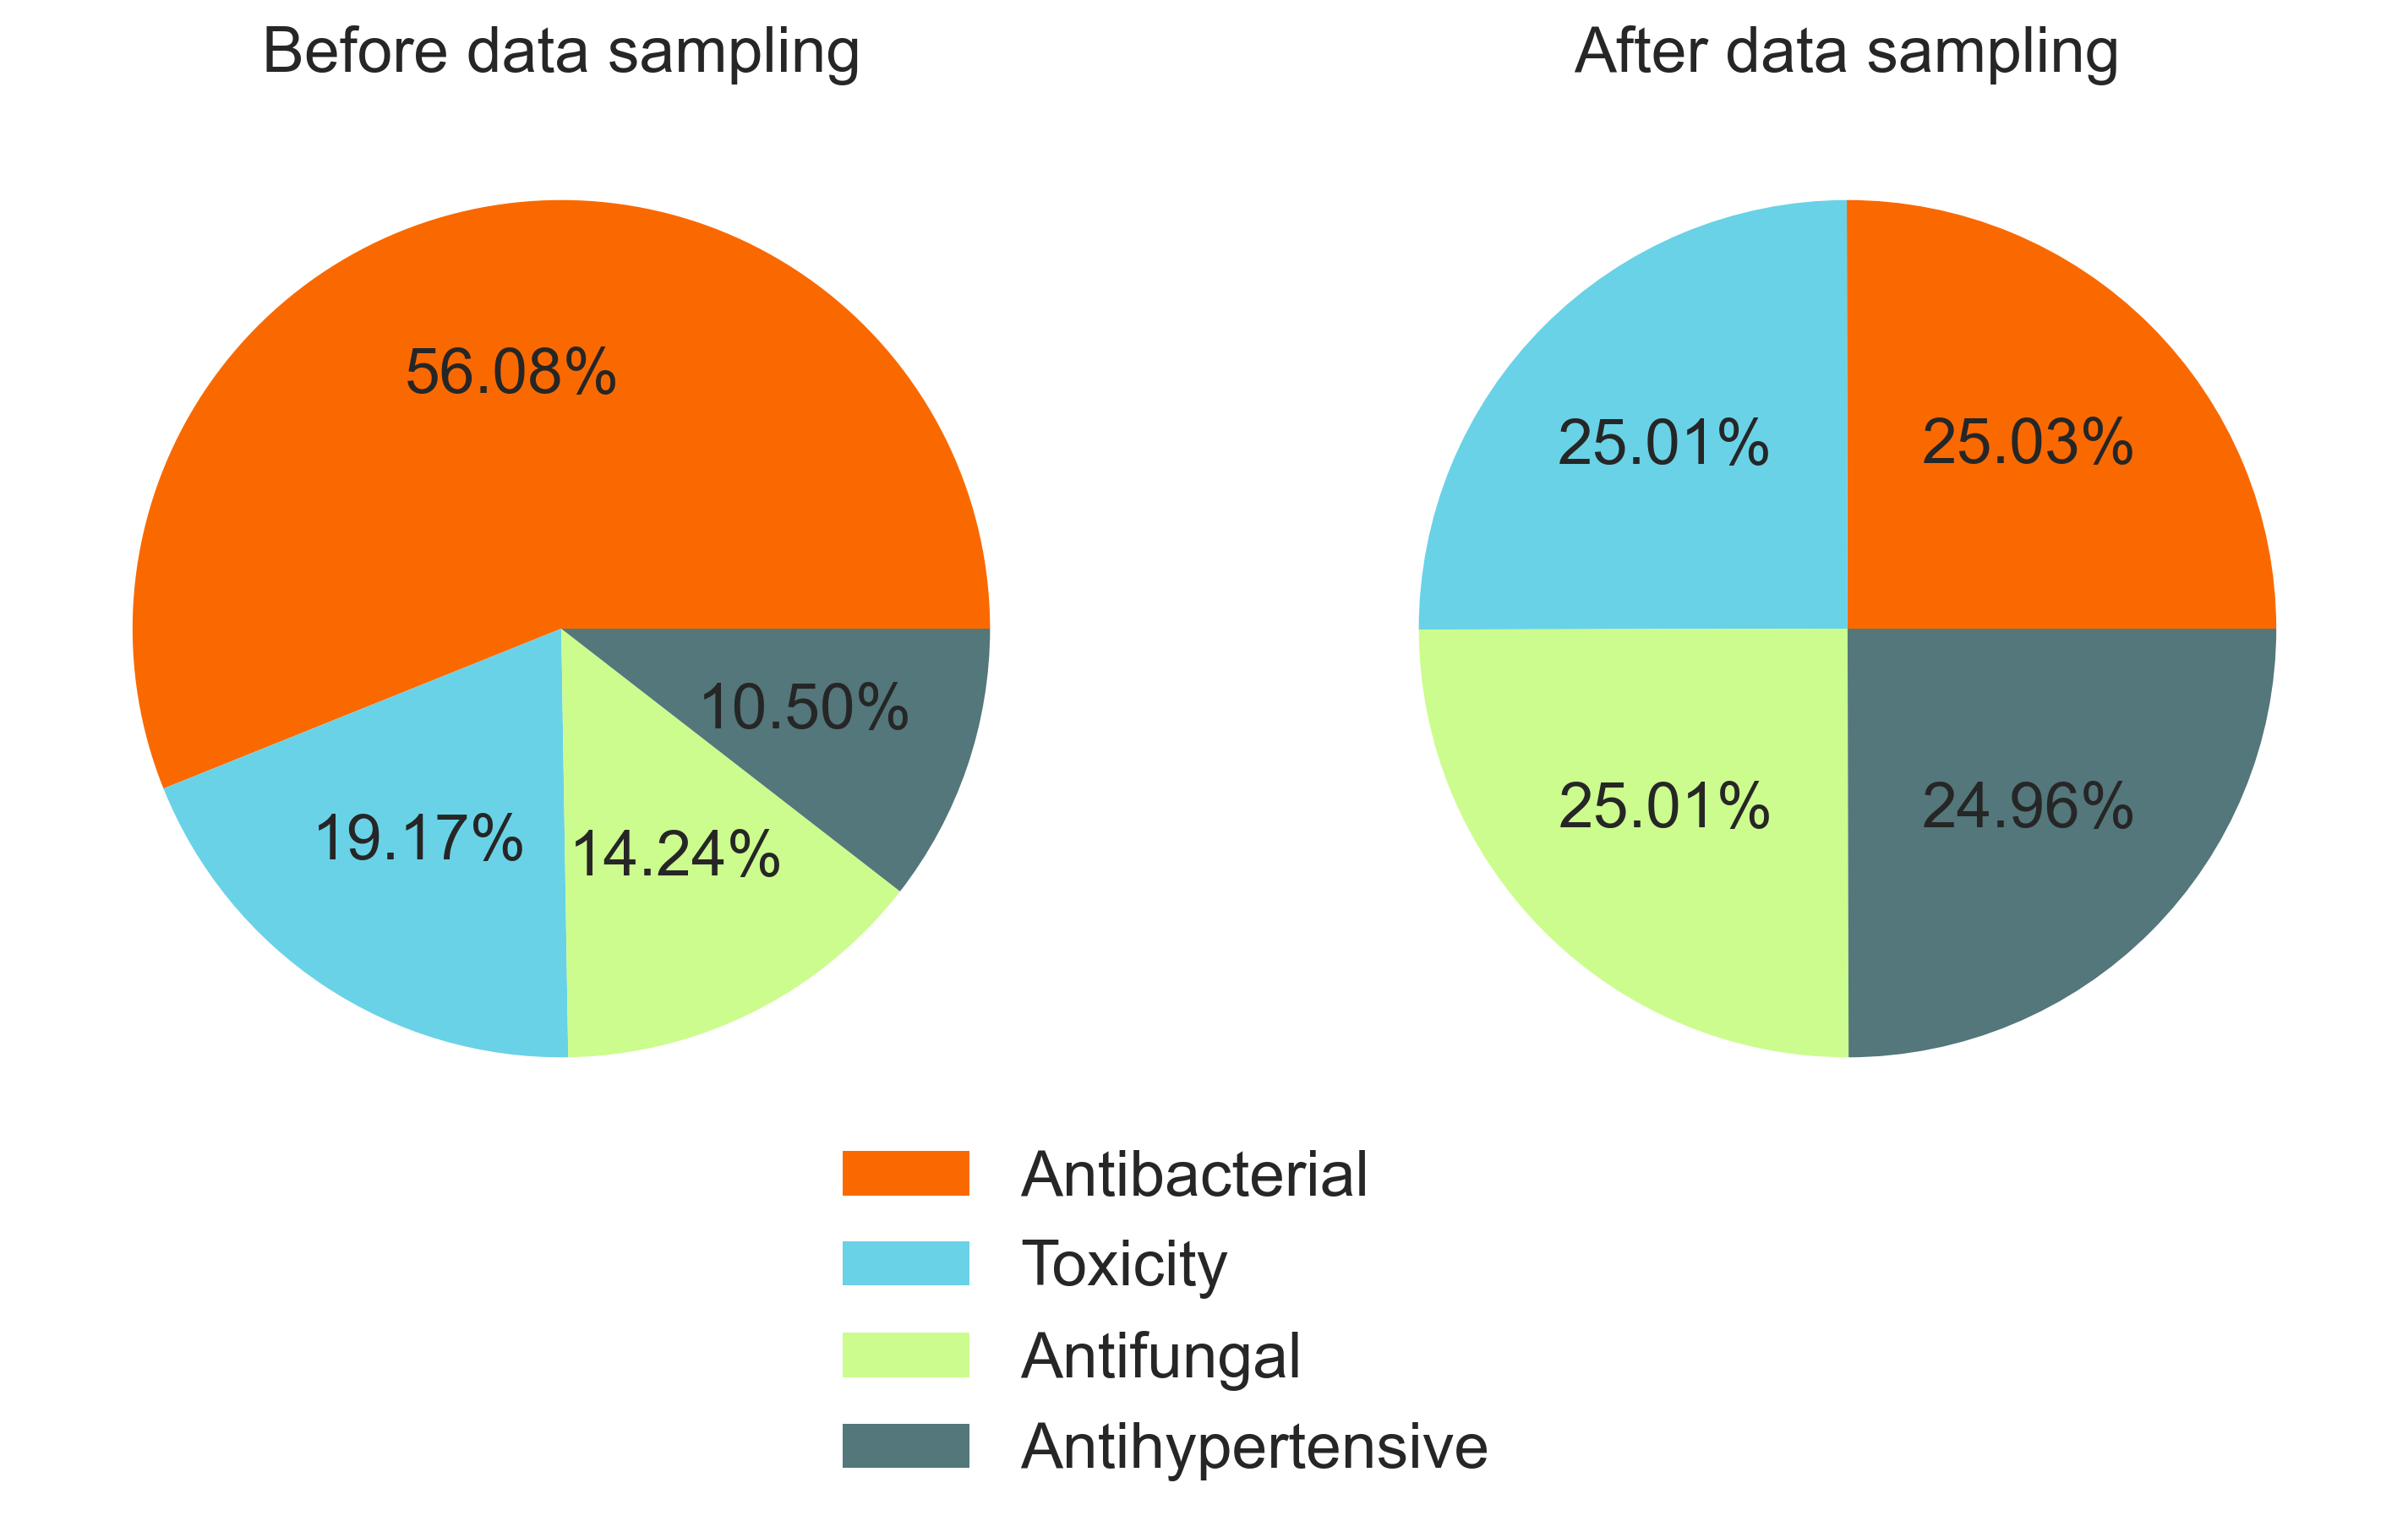

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12),dpi=300)

ax1.set_title('Before data sampling',fontsize=18)
data_y.value_counts().plot.pie(ax=ax1,autopct='%.2f%%', fontsize=18,colors = ['#FA6900', '#69D2E7', '#CCFC8E', '#53777A'],labels=None,ylabel='')

ax2.set_title('After data sampling',fontsize=18)
y_train_res.value_counts().plot.pie(ax=ax2,autopct='%.2f%%', fontsize=18,colors = ['#FA6900', '#69D2E7', '#CCFC8E', '#53777A'],labels=None,ylabel='')

fig.legend(['Antibacterial','Toxicity','Antifungal','Antihypertensive'],fontsize=18,loc='upper center',bbox_to_anchor=(0.5, 0.35))

plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

lgbm_clf = lgbm_model(x_train, y_train)
pre_y_test = lgbm_clf.predict(x_test)
print_precison_recall_f1(y_test, pre_y_test)

In [122]:
y_pred_proba = lgbm_clf.predict_proba(x_test)
def draw_mutiROC(y_test):
    n_classes = 4
    y_score = y_pred_proba
    print(y_score)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    micro_auc = roc_auc_score(y_test, y_score, average='micro')
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    macro_auc = roc_auc_score(y_test, y_score, average='macro')
    print(roc_auc)
    print('micro auc:', micro_auc)
    print('macro auc:', macro_auc)
    plt.figure(figsize=(16.8, 10.5),dpi=300)
    classes_label=['Toxicity','Antifungal','Antihypertensive','Antibacterial']
    colors = ['aqua', 'darkorange', 'cornflowerblue','red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0}, AUC = {1:0.2f}'.format(classes_label[i], roc_auc[i]))
    plt.plot(0, 1,label='Perfect separation',color='green', marker='o')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    legend = plt.legend(loc="best",fontsize=15,frameon=True, fancybox=True)
    legend.get_frame().set_edgecolor('black')
    plt.savefig('save.png')
    plt.show()

[[6.8445435e-05 9.9989223e-01 1.3441469e-05 2.5852489e-05]
 [1.9756259e-04 2.2449717e-04 1.8313011e-05 9.9955958e-01]
 [5.8486046e-05 8.1820972e-04 1.3468113e-04 9.9898857e-01]
 ...
 [9.9942762e-01 5.1473040e-04 3.4316290e-05 2.3353210e-05]
 [1.3714517e-04 3.6660563e-03 1.6052084e-04 9.9603635e-01]
 [9.2461338e-04 9.9900550e-01 5.5696586e-05 1.4179668e-05]]
{0: 0.9922167711689094, 1: 0.9868108741059561, 2: 0.9933487222322558, 3: 0.9954098002484251, 'micro': 0.9954400497076373, 'macro': 0.9924998674050332}
micro auc: 0.9954400497076373
macro auc: 0.9919465419388867


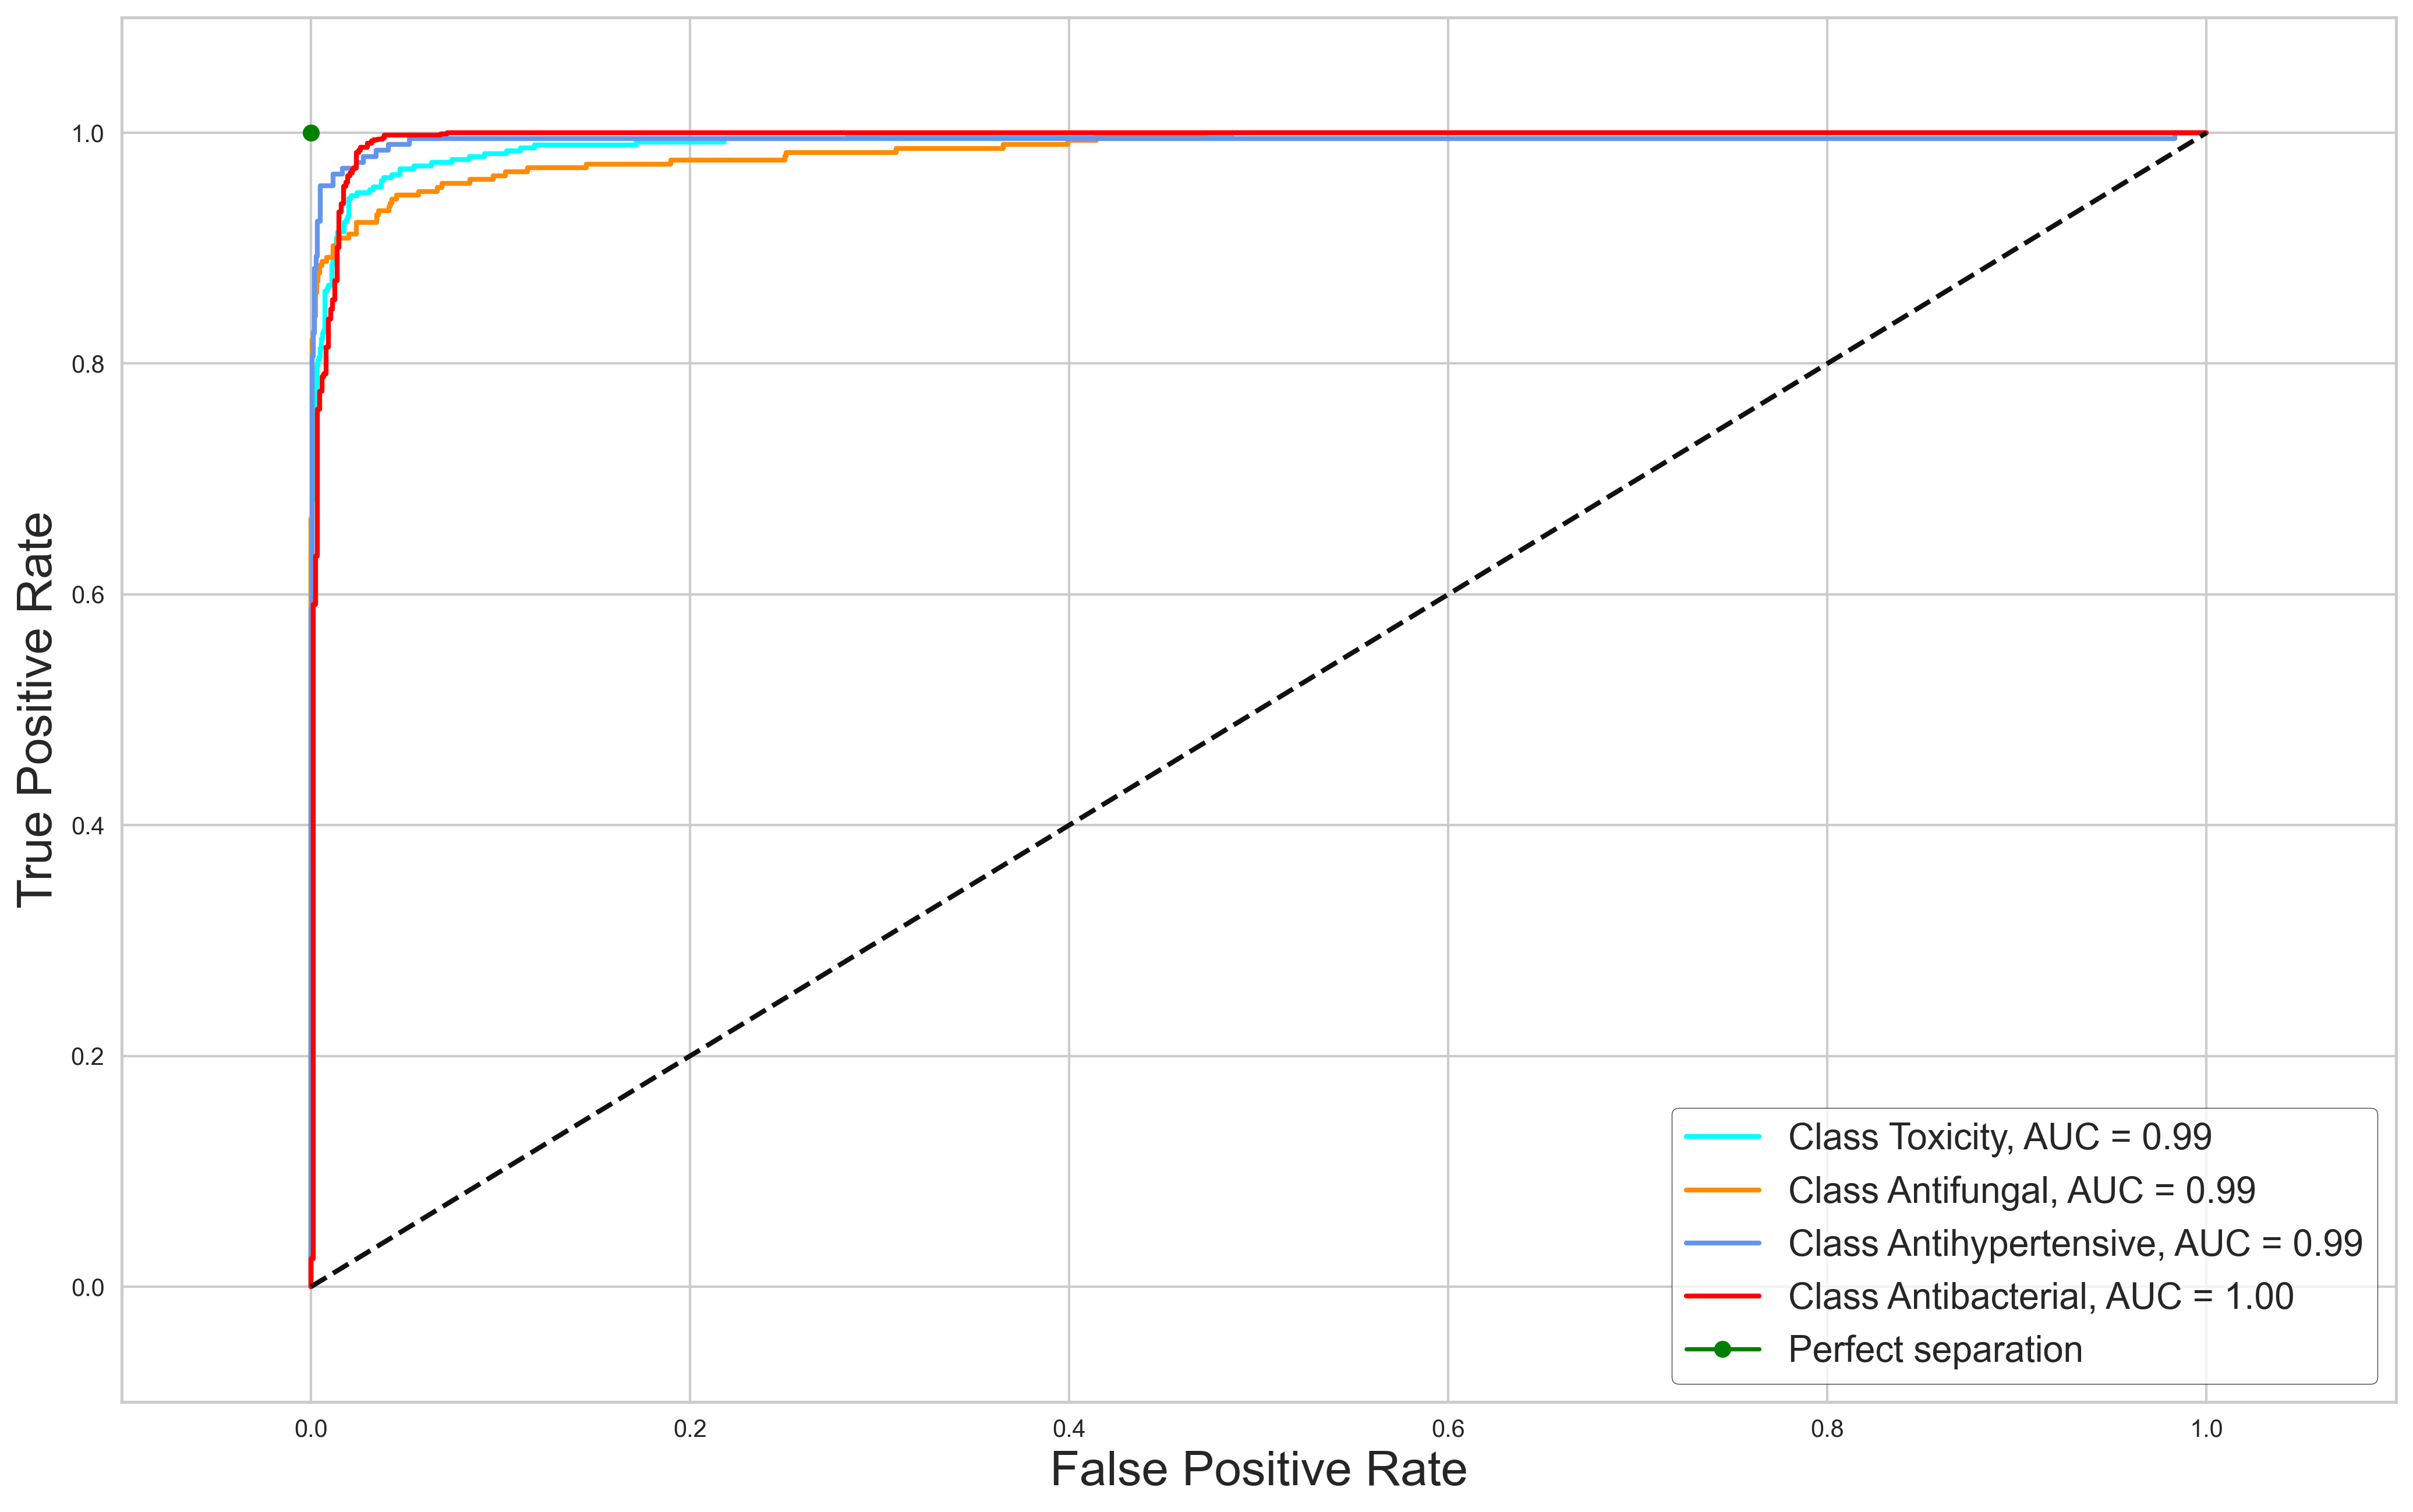

In [123]:
draw_mutiROC(y_test)